In [1]:
import pandas as pd

file_path = 'data/Supplemental_Data_Raw_Genecounts.csv'

# Load the CSV file into a DataFrame.
df = pd.read_csv(file_path)
df = df.drop('Unnamed: 17', axis=1)
df = df.rename(columns={"Unnamed: 0": "mnra",})
df.set_index('mnra', inplace=True)
# Convert every non-index column to int
df = df.apply(pd.to_numeric, errors='coerce', downcast='integer')

# Pruning rows where all the values are 0.
# Assuming that you have columns 'x' and 'y', replace them with the actual names of your columns.
print(df.shape)
df = df[(df.loc[:, df.columns != 'index'] != 0).any(axis=1)]


(24411, 32)


In [2]:
columns_to_check = df.columns.difference(['Unnamed: 0'])

# Pruning rows where all the values in columns_to_check are 0.
df = df[(df[columns_to_check] != 0).any(axis=1)]


In [3]:
df.shape

(20877, 32)

In [4]:
df.columns

Index(['A1.1.1', 'A1.1.2', 'A1.1.3', 'A1.1.4', 'A2.1.1', 'A2.1.2', 'A2.1.3',
       'A2.1.4', 'A2.2.1', 'A2.2.2', 'A2.2.3', 'A2.2.4', 'A2.3.1', 'A2.3.2',
       'A2.3.3', 'A2.3.4', 'B1.1.1', 'B1.1.2', 'B1.1.3', 'B1.1.4', 'B2.1.1',
       'B2.1.2', 'B2.1.3', 'B2.1.4', 'B2.2.1', 'B2.2.2', 'B2.2.3', 'B2.2.4',
       'B2.3.1', 'B2.3.2', 'B2.3.3', 'B2.3.4'],
      dtype='object')

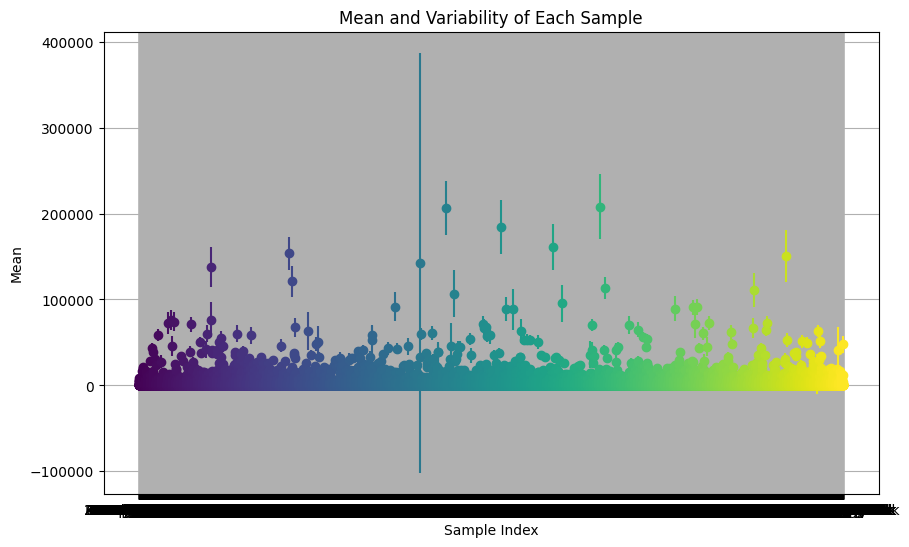

In [5]:
import matplotlib.pyplot as plt

# Calculating the mean and standard deviation for each row
df['mean'] = df[columns_to_check].mean(axis=1)
df['std'] = df[columns_to_check].std(axis=1)
df['cv'] = (df.std(axis=1) / df.mean(axis=1)).abs() * 100

import numpy as np

# Generate a color map
colors = plt.cm.viridis(np.linspace(0, 1, len(df)))

plt.figure(figsize=(10, 6))
for idx, color in zip(df.index, colors):
    plt.errorbar(idx, df.loc[idx, 'mean'], yerr=df.loc[idx, 'std'], fmt='o', color=color)

plt.title('Mean and Variability of Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('Mean')
plt.grid(True)
plt.show()

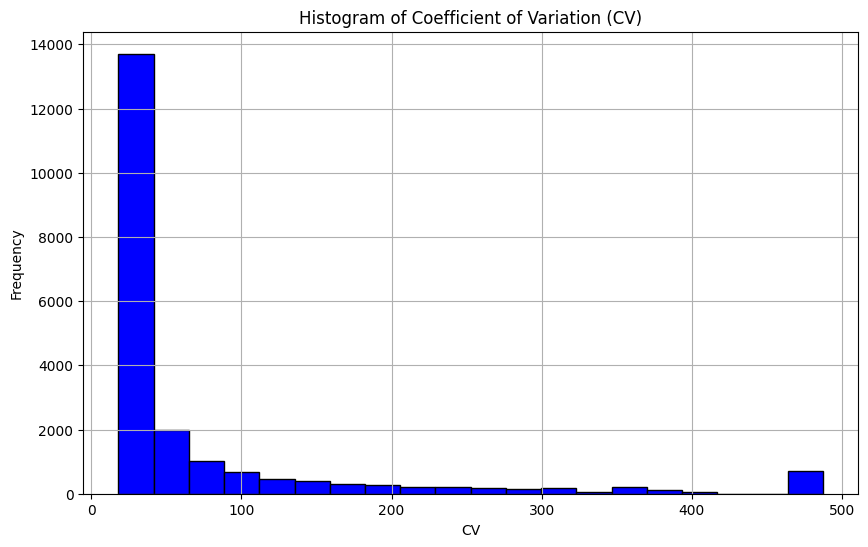

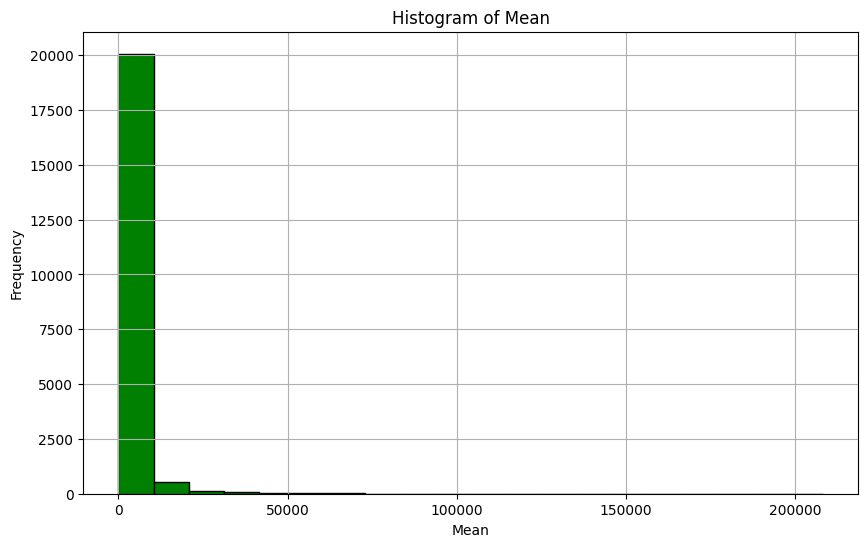

In [6]:
# Plotting histogram for df['cv']
plt.figure(figsize=(10,6))
plt.hist(df['cv'], bins=20, color='blue', edgecolor='black')
plt.title('Histogram of Coefficient of Variation (CV)')
plt.xlabel('CV')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plotting histogram for df['mean']
plt.figure(figsize=(10,6))
plt.hist(df['mean'], bins=20, color='green', edgecolor='black')
plt.title('Histogram of Mean')
plt.xlabel('Mean')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

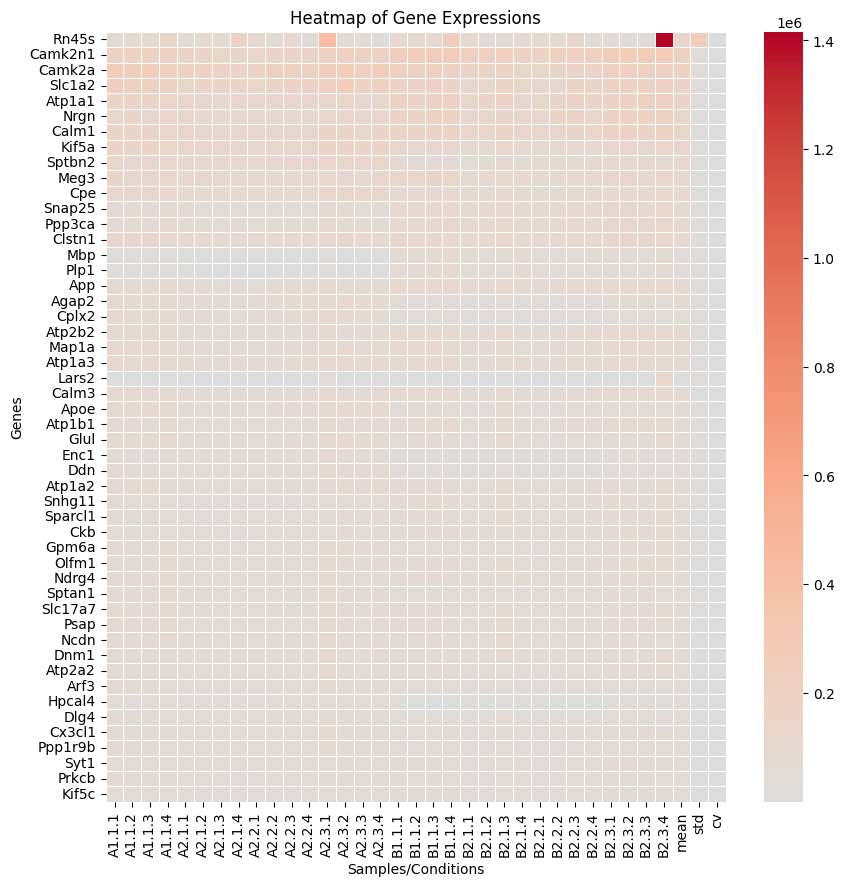

In [7]:
import seaborn as sns

# Or, if you want to plot the raw counts or normalized counts, you can skip the correlation computation and directly plot the DataFrame
plt.figure(figsize=(10, 10))  # You can specify the figure size as per your requirement

n = 50  # You can set the number of genes you want to display
df_high_variance = df.loc[df.var(axis=1).nlargest(n).index]


# Plot the heatmap
sns.heatmap(df_high_variance, cmap='coolwarm', center=0, linewidths=.5)  # You can customize the colormap, center value, and linewidths

# Add title and labels if needed
plt.title('Heatmap of Gene Expressions')
plt.xlabel('Samples/Conditions')
plt.ylabel('Genes')

# Show the plot
plt.show()


In [19]:
from scipy import stats
import numpy as np

# Define the groups you want to compare
group_a_cols = [col for col in df.columns if 'A' in col]
group_b_cols = [col for col in df.columns if 'B' in col]

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['gene', 'mean_group_a', 'mean_group_b', 'p_value'])

for index, row in df.iterrows():
    group_a_data = row[group_a_cols]
    group_b_data = row[group_b_cols]
    
    # Compute the mean expression level for each group
    mean_group_a = np.mean(group_a_data)
    mean_group_b = np.mean(group_b_data)
    
    # Perform a t-test between the two groups
    t_stat, p_value = stats.ttest_ind(group_a_data, group_b_data, equal_var=False, nan_policy='omit')
    
    # Append the results to the results DataFrame
    results_df = results_df.append({
        'gene': index,
        'mean_group_a': mean_group_a,
        'mean_group_b': mean_group_b,
        'p_value': p_value
    }, ignore_index=True)

# Correct for multiple testing (optional)
results_df['adjusted_p_value'] = stats.multipletests(results_df['p_value'], method='fdr_bh')[1]

# Filter the results based on a significance threshold, for example, adjusted p-value < 0.05
significant_genes = results_df[results_df['adjusted_p_value'] < 0.05]


AttributeError: 'DataFrame' object has no attribute 'append'